# Иследовательский анализ данных

### Описание данных в images.csv

В качестве данных будут использоваться изображения из базы данных MNIST.

MNIST состоит из чёрно-белых изображений рукописных цифр. В базе представлены
изображения цифр от 0 до 9. Каждое изображение имеет разрешение 28×28 пикселей.
В данных представлено 42 000 изображений. Это подмножество всех данных,
доступных в MNIST.

Изображение размером 28×28 представляется в виде последовательности из 784
чисел — по одному числу на каждый пиксель изображения. Каждое число находится
в диапазоне от 0 до 255. Чем больше число, тем выше интенсивность пикселя.
Нулевой интенсивности соответствует абсолютно чёрный пиксель, максимальной —
абсолютно белый.

Каждое изображение представляется в виде строчки в таблице images.csv. В
таблице есть колонки pixel0, pixel1 и так далее до pixel783, каждая из которых
соответствует значению конкретного пикселя изображения. Также в таблице есть
колонка label, в которой находится информация о том, какая цифра представлена
на изображении.

В рамках проекта нужно по значениям колонок, названия которых начинаются со
слова pixel, научиться предсказывать значение в колонке label.

### Загрузка и первичное исследование данных MNIST

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from IPython.display import display

In [2]:
# Чтение данных
sns.set(rc={'figure.figsize': (11.7, 8.27)})
data = pd.read_csv('../../data/images.csv')

print(f'Размерность данных: {data.shape}')
print('\nПервые 5 строк данных:')
display(data.head())

Размерность данных: (42000, 785)

Первые 5 строк данных:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Проверка на наличие пропущенных значений
missing_values = data.isnull().sum().sum()
print(f'Количество пропущенных значений: {missing_values}')

Количество пропущенных значений: 0


### Анализ распределения классов (цифр 0-9)

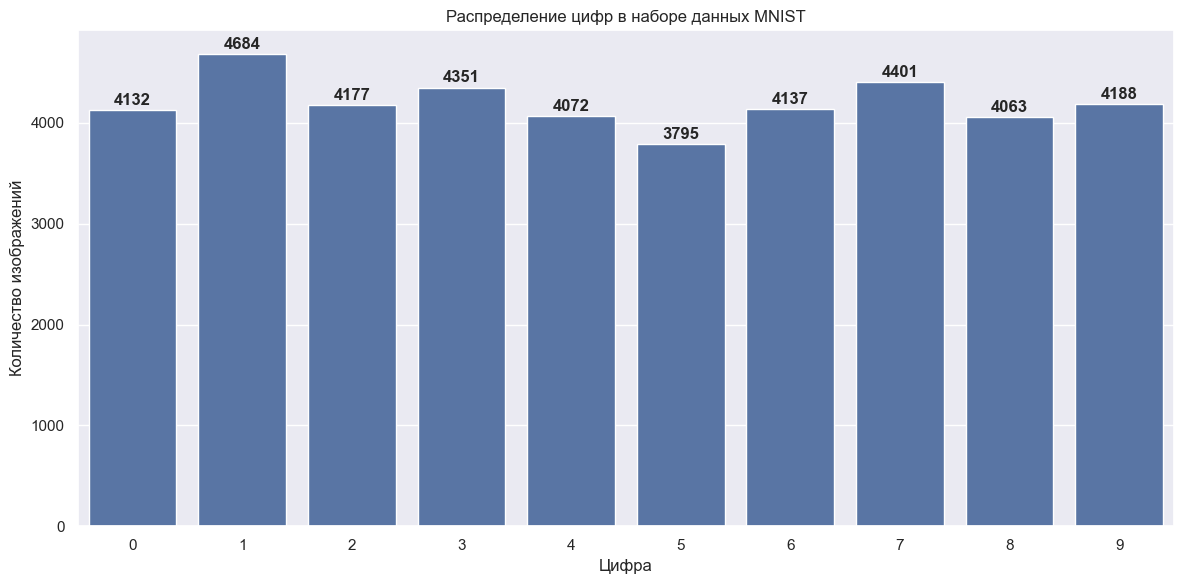

In [4]:
class_distribution = data['label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Распределение цифр в наборе данных MNIST')
plt.xlabel('Цифра')
plt.ylabel('Количество изображений')

# Добавление значений на столбцы
for i, v in enumerate(class_distribution.values):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Наблюдается сбалансированное распределение классов, что является благоприятным фактором для обучения модели.

### Разделение данных на обучающую и тестовую выборки

In [5]:
x = data.drop(columns='label')
y = data['label']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=52)

print(f'Размер обучающей выборки: {x_train.shape[0]}')
print(f'Размер тестовой выборки: {x_test.shape[0]}')

Размер обучающей выборки: 33600
Размер тестовой выборки: 8400


### Визуализация примеров изображений

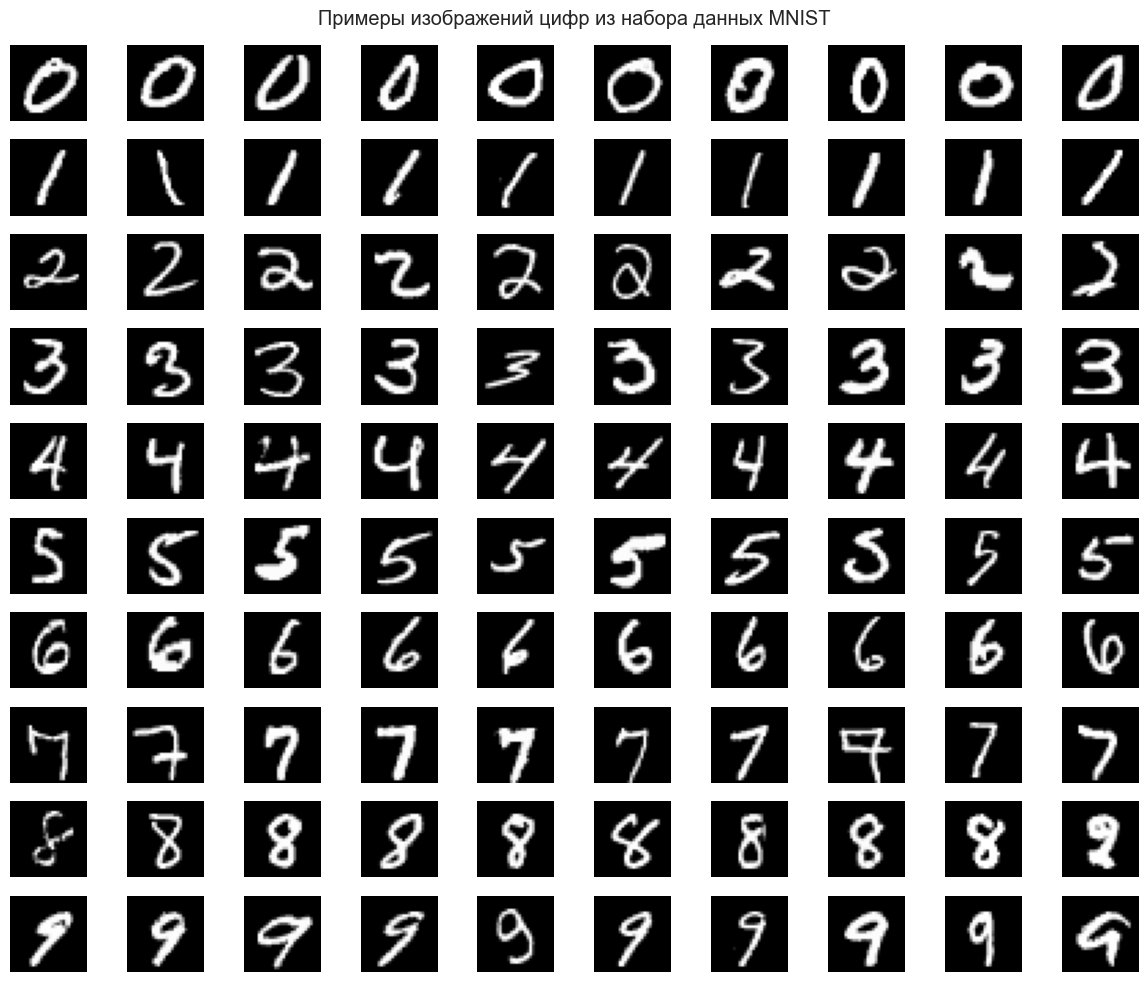

In [6]:
def plot_digit(image_flat, ax=None):
    """Визуализирует одно изображение цифры"""
    image = image_flat.reshape(28, 28).astype('uint8')

    if ax is None:
        plt.figure(figsize=(4, 4))
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(image, cmap='gray')
        ax.axis('off')

# Создание объединенного DataFrame с признаками и метками
x_y_train = x_train.copy(deep=True)
x_y_train['label'] = y_train

# Визуализация 10 случайных примеров для каждого класса
fig, axs = plt.subplots(10, 10, figsize=(12, 10), sharex=True, sharey=True)
group_n = 0
for _, group in x_y_train.groupby('label', as_index=False):
    random_numbers = group.sample(10).drop(columns='label')
    image_vects = [x.values for _, x in random_numbers.iterrows()]

    image_n = 0
    for image in image_vects:
        plot_digit(image, ax=axs[group_n][image_n])
        image_n += 1

    group_n += 1

plt.suptitle('Примеры изображений цифр из набора данных MNIST')
plt.tight_layout()
plt.show()

Наличие в тренировочном датасете множества вариантов начертания одних и тех же цифр позволяет модели выявлять различные признаки и абстрагироваться от индивидуальных особенностей почерка. Это напрямую влияет на улучшение метрик качества модели.

### Анализ статистических характеристик пикселей

In [7]:
# Статистика по пикселям
pixel_stats = x_train.describe()
print('Статистика по пикселям:')
display(pixel_stats.loc[['mean', 'std', 'min', 'max']].T)

Статистика по пикселям:


,mean,std,min,max
pixel0,0.000000,0.00000,0.0,0.0
pixel1,0.000000,0.00000,0.0,0.0
pixel2,0.000000,0.00000,0.0,0.0
pixel3,0.000000,0.00000,0.0,0.0
pixel4,0.000000,0.00000,0.0,0.0
...,...,...,...,...
pixel779,0.003571,0.46316,0.0,62.0
pixel780,0.000000,0.00000,0.0,0.0
pixel781,0.000000,0.00000,0.0,0.0
pixel782,0.000000,0.00000,0.0,0.0


Анализ распределения пикселей выявил значительный разброс значений. Однако нормализацией пренебрежем, так как данные уже приведены к стандартному диапазону [0, 255].

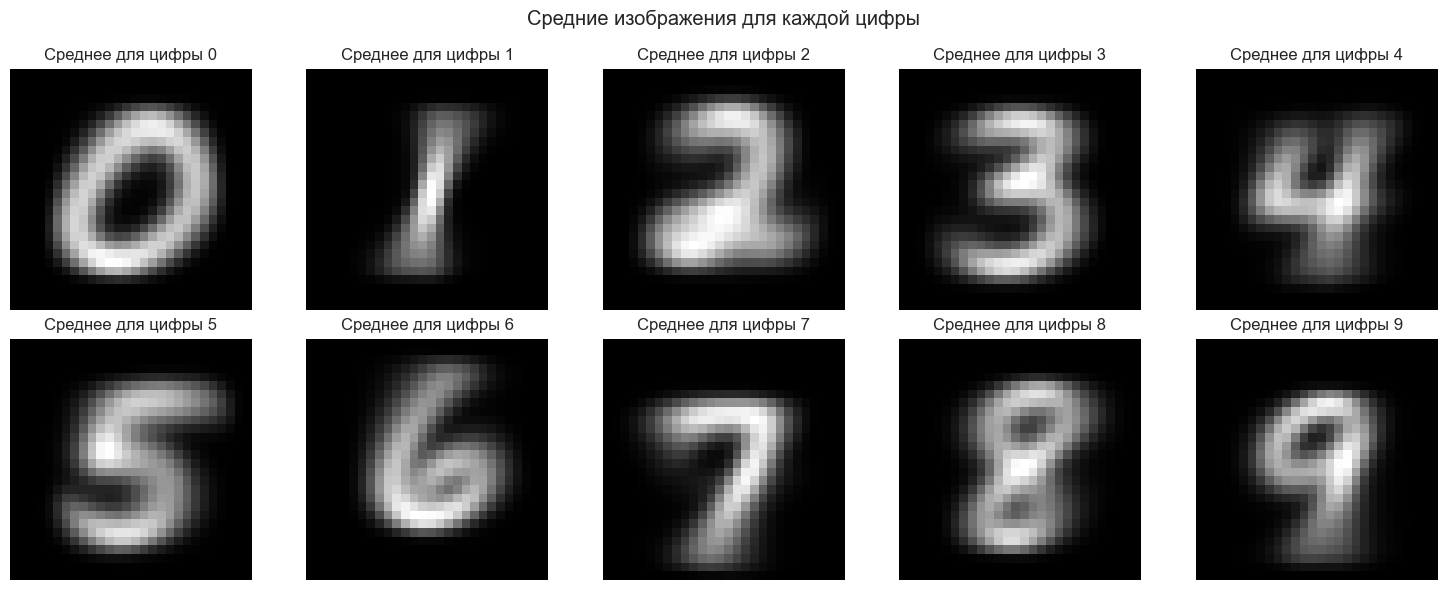

In [8]:
# Анализ средних значений пикселей для каждой цифры
mean_digits = []
for digit in range(10):
    digit_mean = x_train[y_train == digit].mean().values.reshape(28, 28)
    mean_digits.append(digit_mean)

# Визуализация средних изображений для каждой цифры
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for digit in range(10):
    axes[digit].imshow(mean_digits[digit], cmap='gray')
    axes[digit].set_title(f'Среднее для цифры {digit}')
    axes[digit].axis('off')

plt.suptitle('Средние изображения для каждой цифры')
plt.tight_layout()
plt.show()

Усредненные изображения визуализируют наиболее характерные признаки цифр, формируя их эталонное представление. Это помогает выявить ключевые паттерны, которые модель должна научиться распознавать.

### Анализ вариативности пикселей

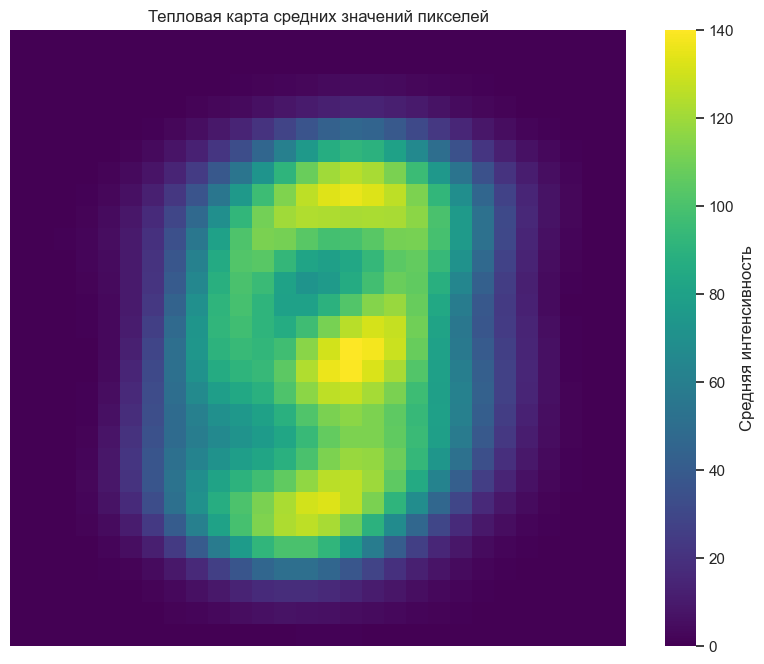

In [9]:
# Тепловая карта средних значений пикселей
plt.figure(figsize=(10, 8))
sns.heatmap(pixel_stats.loc['mean'].values.reshape(28, 28), cmap='viridis',
            square=True, cbar_kws={'label': 'Средняя интенсивность'})
plt.title('Тепловая карта средних значений пикселей')
plt.axis('off')
plt.show()

Анализ тепловой карты средних значений пикселей выявляет три статистически значимых кластера, а также общий контур, определяющий типичную зону расположения цифры.

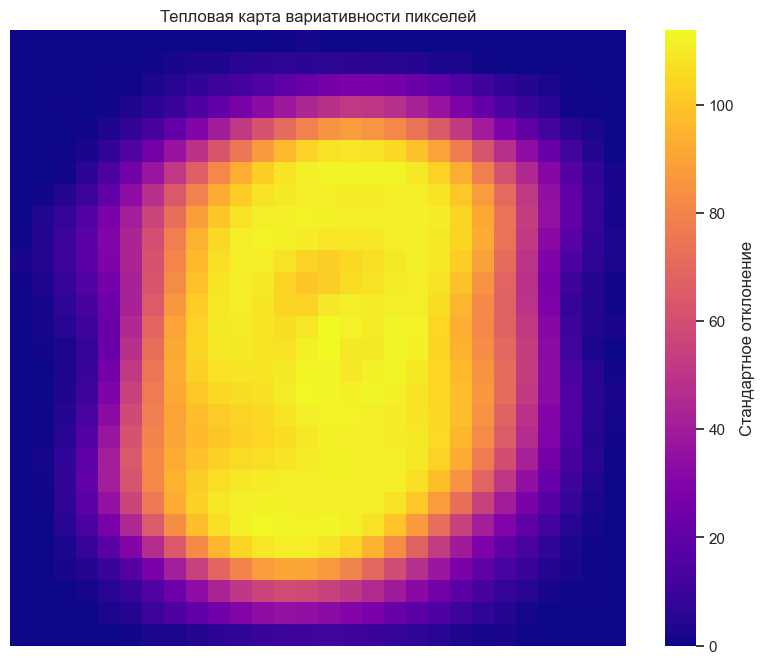

In [10]:
# Тепловая карта стандартных отклонений пикселей
plt.figure(figsize=(10, 8))
sns.heatmap(pixel_stats.loc['std'].values.reshape(28, 28), cmap='plasma',
            square=True, cbar_kws={'label': 'Стандартное отклонение'})
plt.title('Тепловая карта вариативности пикселей')
plt.axis('off')
plt.show()

Анализ тепловой карты вариативности подтверждает, что максимальная дисперсия пикселей сосредоточена в центре изображения — в области нахождения цифр. Периферийные же пиксели демонстрируют низкую дисперсию, что позволяет классифицировать их как малоинформативные. Это указывает на потенциальную возможность уменьшить размерность данных без потери качества модели.

### Отбор информативных факторов (пикселей)

Обрабатывать данные, представленные в виде пикселей изображения, в нашем случае довольно сложно, и нет очевидного подхода к работе с ними. Тем не менее, в качестве эксперимента попробуем отбросить маловариативные пиксели.

In [11]:
# Анализ пикселей с низкой вариативностью
low_variance_pixels = (pixel_stats.loc['std'] < 5).sum()
percent_low_variance_pixels = low_variance_pixels / 784 * 100
print('Отбор информативных факторов:')
print(f'Количество пикселей с низкой вариативностью: {low_variance_pixels}')
print(f'Процент маловариативных пикселей: {percent_low_variance_pixels:.1f}%')

Отбор информативных факторов:
Количество пикселей с низкой вариативностью: 200
Процент маловариативных пикселей: 25.5%


In [12]:
# Отбор факторов на основе порога дисперсии
selector = VarianceThreshold(threshold=0.1)
selector.fit(x_train)

# Анализ отобранных факторов
selected_features = selector.get_feature_names_out()
print(f'Всего факторов: {x_train.shape[1]}')
print(f'Отобрано информативных факторов: {len(selected_features)}')

Всего факторов: 784
Отобрано информативных факторов: 686


In [13]:
# Применение отбора факторов
x_train_selected = x_train[selected_features]
x_test_selected = x_test[selected_features]

print('Размерность после отбора факторов:')
print(f'Обучающая выборка: {x_train_selected.shape}')
print(f'Тестовая выборка: {x_test_selected.shape}')

Размерность после отбора факторов:
Обучающая выборка: (33600, 686)
Тестовая выборка: (8400, 686)


In [14]:
print('Первые 5 строк оптимизированных данных:')
display(x_train_selected.head())

Первые 5 строк оптимизированных данных:


,pixel12,pixel13,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,...,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779
12344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Создание и обучение модели

In [15]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

### Загрузка и подготовка данных

In [16]:
# Чтение данных
x_train = x_train_selected
y_train = y_train
x_test = x_test_selected
y_test = y_test

print(f'Размер обучающей выборки: {x_train.shape}')
print(f'Размер тестовой выборки: {x_test.shape}')

Размер обучающей выборки: (33600, 686)
Размер тестовой выборки: (8400, 686)


In [17]:
# Определение размера изображения на основе отобранных пикселей
n_pixels = x_train.shape[1]
# Ближайший квадратный размер
img_size = int(np.sqrt(n_pixels))
print(f'Предполагаемый размер изображения: {img_size}x{img_size} = '
      f'{img_size ** 2} пикселей')
print(f'Фактическое количество пикселей: {n_pixels} (из 784 возможных)')

Предполагаемый размер изображения: 26x26 = 676 пикселей
Фактическое количество пикселей: 686 (из 784 возможных)


In [18]:
# Разделение данных на обучающую и тестовую выборки (80%:20%)
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=52)

print(f'Размер обучающей выборки: {x_train_split.shape}')
print(f'Размер валидационной выборки: {x_val.shape}')

Размер обучающей выборки: (26880, 686)
Размер валидационной выборки: (6720, 686)


In [19]:
def print_image(pixels, ax=None, title=None, original_size=28):
    """Визуализирует изображение из массива пикселей с учетом
    уменьшенной размерности"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))

    # Создание массива нулей размером 28x28 = 784 пикселя (для изображения)
    full_image = np.zeros(original_size ** 2)

    # Заполнение данными только тех пикселей, которые есть в итоговых данных
    # (формат имени пикселей в данных - "pixelX", где X - число)
    pixel_indices = []
    for col in x_train.columns:
        if col.startswith('pixel'):
            try:
                # Извлечение номера пикселя из названия
                idx = int(col[5:])
                pixel_indices.append(idx)
            except ValueError:
                continue

    # Сортировка индексов и заполнение значений
    pixel_indices.sort()
    for i, pixel_idx in enumerate(pixel_indices[:len(pixels)]):
        if pixel_idx < len(full_image):
            full_image[pixel_idx] = pixels[i]

    # Преобразование линейного массива в матрицу 28x28
    image = full_image.reshape(original_size, original_size)
    # Настройка внешнего вида
    ax.imshow(image, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)

    return ax

### Создание и обучение моделей

Для решения задачи будем обучать шесть моделей с разными гиперпараметрами: три дерева принятия решений и три случайного леса. В итоге лучшая модель будет выбрана по наивысшим результатам на метриках качества.

In [20]:
# Словарь всех моделей и результатов их работы
models_results = {}

# Деревья принятия решений с разными гиперпараметрами
min_samples_leaf_values = [1, 3, 5, 10]

print('Обучение деревьев принятия решений...')
for min_leaf in min_samples_leaf_values:
    print(f'\nОбучение DecisionTree (min_samples_leaf={min_leaf})...')
    print(f'Название модели: DT_leaf_{min_leaf}')

    # Создание и обучение модели
    model_dt = DecisionTreeClassifier(min_samples_leaf=min_leaf,
                                      criterion='gini', random_state=52)
    model_dt.fit(x_train_split, y_train_split)

    # Предсказания модели
    train_pred = model_dt.predict(x_train_split)
    val_pred = model_dt.predict(x_val)

    # Точность модели
    train_accuracy = accuracy_score(y_train_split, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)

    # Сохранение данных в словаре всех моделей
    models_results[f'DT_leaf_{min_leaf}'] = {
        'model': model_dt,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    }

    print(f'Точность модели на обучающей выборке: {train_accuracy}')
    print(f'Точность модели на валидационной выборке: {val_accuracy}')
    print(f'Разница точностей: {train_accuracy - val_accuracy}')

Обучение деревьев принятия решений...

Обучение DecisionTree (min_samples_leaf=1)...
Название модели: DT_leaf_1
Точность модели на обучающей выборке: 1.0
Точность модели на валидационной выборке: 0.843452380952381
Разница точностей: 0.15654761904761905

Обучение DecisionTree (min_samples_leaf=3)...
Название модели: DT_leaf_3
Точность модели на обучающей выборке: 0.9581473214285714
Точность модели на валидационной выборке: 0.8398809523809524
Разница точностей: 0.118266369047619

Обучение DecisionTree (min_samples_leaf=5)...
Название модели: DT_leaf_5
Точность модели на обучающей выборке: 0.9375744047619048
Точность модели на валидационной выборке: 0.8464285714285714
Разница точностей: 0.09114583333333337

Обучение DecisionTree (min_samples_leaf=10)...
Название модели: DT_leaf_10
Точность модели на обучающей выборке: 0.9053943452380953
Точность модели на валидационной выборке: 0.8340773809523809
Разница точностей: 0.07131696428571432


In [21]:
# Случайный лес с разными гиперпараметрами
n_estimators_values = [100, 300, 500, 1000]

print('Обучение случайного леса...')
for n_est in n_estimators_values:
    print(f'\nОбучение RandomForest (n_estimators={n_est})...')
    print(f'Название модели: RF_est_{n_est}')

    # Создание и обучение модели
    model_rf = RandomForestClassifier(n_estimators=n_est, min_samples_leaf=3,
                                      max_features='sqrt', criterion='gini',
                                      random_state=52, n_jobs=-1)
    model_rf.fit(x_train_split, y_train_split)

    # Предсказания модели
    train_pred = model_rf.predict(x_train_split)
    val_pred = model_rf.predict(x_val)

    # Точность модели
    train_accuracy = accuracy_score(y_train_split, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)

    # Сохранение данных в словаре всех моделей
    models_results[f'RF_est_{n_est}'] = {
        'model': model_rf,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy
    }

    print(f'Точность модели на обучающей выборке: {train_accuracy}')
    print(f'Точность модели на валидационной выборке: {val_accuracy}')
    print(f'Разница точностей: {train_accuracy - val_accuracy}')

Обучение случайного леса...

Обучение RandomForest (n_estimators=100)...
Название модели: RF_est_100
Точность модели на обучающей выборке: 0.996875
Точность модели на валидационной выборке: 0.9583333333333334
Разница точностей: 0.038541666666666585

Обучение RandomForest (n_estimators=300)...
Название модели: RF_est_300
Точность модели на обучающей выборке: 0.9969866071428571
Точность модели на валидационной выборке: 0.9607142857142857
Разница точностей: 0.0362723214285714

Обучение RandomForest (n_estimators=500)...
Название модели: RF_est_500
Точность модели на обучающей выборке: 0.9973214285714286
Точность модели на валидационной выборке: 0.9602678571428571
Разница точностей: 0.03705357142857146

Обучение RandomForest (n_estimators=1000)...
Название модели: RF_est_1000
Точность модели на обучающей выборке: 0.9972098214285714
Точность модели на валидационной выборке: 0.9617559523809524
Разница точностей: 0.03545386904761905


### Выбор лучшей модели для дальнейшего анализа

In [22]:
best_model_name = max(models_results.keys(),
                      key=lambda x: models_results[x]['val_accuracy'])
best_model = models_results[best_model_name]['model']

print(f'Лучшая модель: {best_model_name}')
print(f'Точность на валидационной выборке: {models_results[
    best_model_name]['val_accuracy']}')

Лучшая модель: RF_est_1000
Точность на валидационной выборке: 0.9617559523809524


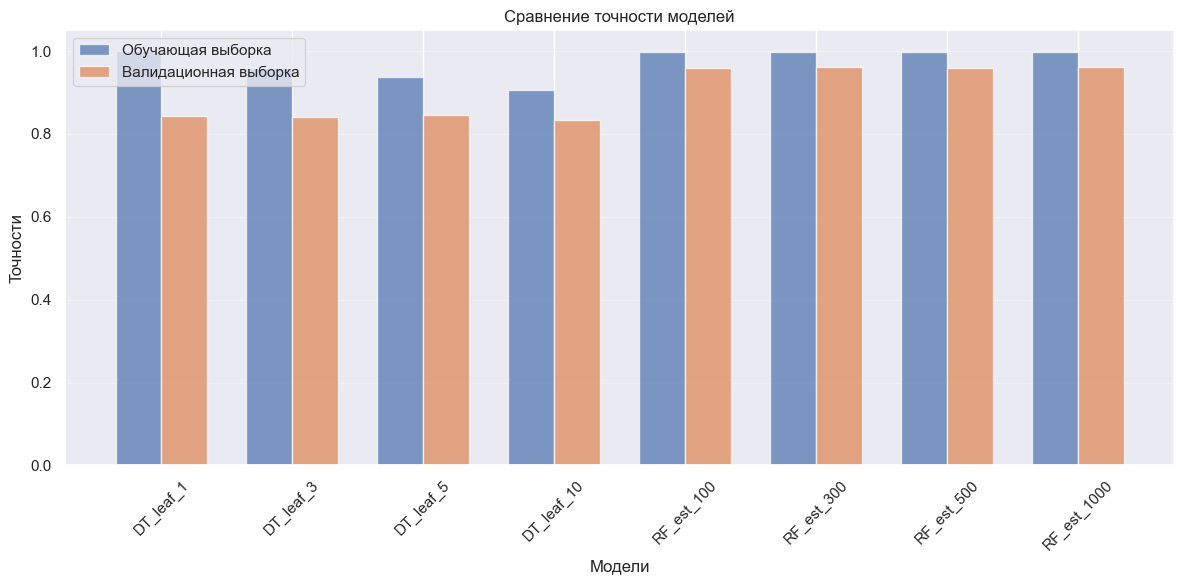

In [23]:
# Визуализация сравнения моделей
sns.set(rc={'figure.figsize': (11.7, 8.27)})
plt.figure(figsize=(12, 6))
models_names = list(models_results.keys())
list_train_accuracy = [models_results[name]['train_accuracy']
                       for name in models_names]
list_val_accuracy = [models_results[name]['val_accuracy']
                     for name in models_names]

x_pos = np.arange(len(models_names))
width = 0.35
plt.bar(x_pos - width / 2, list_train_accuracy, width,
        label='Обучающая выборка', alpha=0.7)
plt.bar(x_pos + width / 2, list_val_accuracy, width,
        label='Валидационная выборка', alpha=0.7)

plt.xlabel('Модели')
plt.ylabel('Точности')
plt.title('Сравнение точности моделей')
plt.xticks(x_pos, models_names, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Модели случайного леса в среднем демонстрируют более высокую точность на валидационной выборке по сравнению с деревьями принятия решений. При этом разница в точности между самими моделями случайного леса является незначительной.

### Оценка качества лучшей модели на валидационной выборке

In [24]:
best_val_pred = best_model.predict(x_val)

# Метрики качества модели
best_val_accuracy = accuracy_score(y_val, best_val_pred)
best_val_precision = precision_score(y_val, best_val_pred,
                                     average='weighted', zero_division=0)
best_val_recall = recall_score(y_val, best_val_pred,
                               average='weighted', zero_division=0)
best_val_f1 = f1_score(y_val, best_val_pred,
                       average='weighted', zero_division=0)

print(f'Метрики качества модели {best_model_name} на '
      f'валидационной выборке:')
print(f'Accuracy: {best_val_accuracy}')
print(f'Precision: {best_val_precision}')
print(f'Recall: {best_val_recall}')
print(f'F1-score: {best_val_f1}')

Метрики качества модели RF_est_1000 на валидационной выборке:
Accuracy: 0.9617559523809524
Precision: 0.961737322842056
Recall: 0.9617559523809524
F1-score: 0.9616897890588718


Лучшая модель демонстрирует сбалансированно высокое качество классификации: все ключевые метрики качества (Accuracy, Precision, Recall, F1-score) стабильно превышают 96%. Результаты указывают на ее надежность в распознавании цифр.

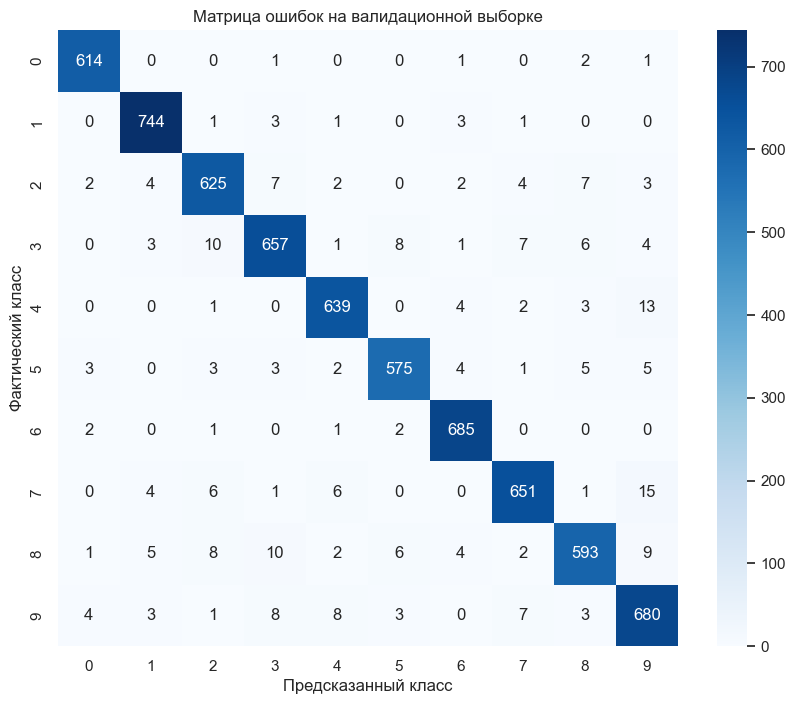

In [25]:
# Визуализация матрицы ошибок
cm = confusion_matrix(y_val, best_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Матрица ошибок на валидационной выборке')
plt.xlabel('Предсказанный класс')
plt.ylabel('Фактический класс')
plt.show()

Матрица ошибок подтверждает высокую эффективность модели в распознавании цифр. Большинство значений сконцентрировано на главной диагонали, что свидетельствует о минимальном количестве ошибок классификации.

### Анализ ошибок лучшей модели на валидационной выборке

In [26]:
error_mask = best_val_pred != y_val
x_errors =  x_val[error_mask]
y_errors_true = y_val[error_mask]
y_errors_pred = best_val_pred[error_mask]

print(f'Количество ошибок: {len(x_errors)}')
print(f'Доля ошибок: {len(x_errors) / len(y_val):.4f}')

Количество ошибок: 257
Доля ошибок: 0.0382


In [27]:
# Анализ самых частых ошибок
error_counts = pd.DataFrame({
    'true': y_errors_true,
    'pred': y_errors_pred
}).value_counts().head(10).reset_index()
error_counts.columns = ['Истинный класс', 'Предсказанный класс', 'Количество']

print(f'Самые частые ошибки:')
display(error_counts.reset_index(drop=True))

Самые частые ошибки:


,Истинный класс,Предсказанный класс,Количество
0,7,9,15
1,4,9,13
2,8,3,10
3,3,2,10
4,8,9,9
5,9,4,8
6,8,2,8
7,3,5,8
8,9,3,8
9,2,3,7


Анализ таблицы ошибок позволяет выявить наиболее частые случаи неверной классификации. Для углубленного исследования причин этих ошибок выполним визуализацию самых распространенных примеров.

Визуализация ошибок 7 -> 9 (количество: 15)


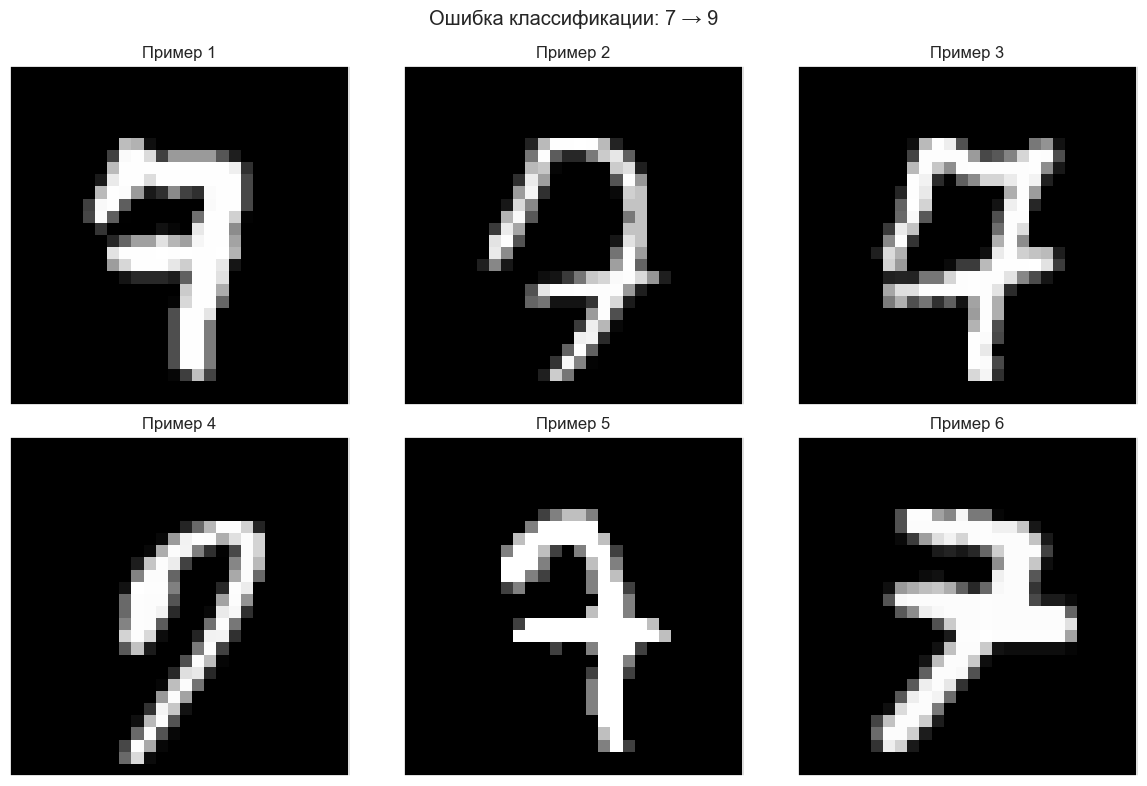

Визуализация ошибок 4 -> 9 (количество: 13)


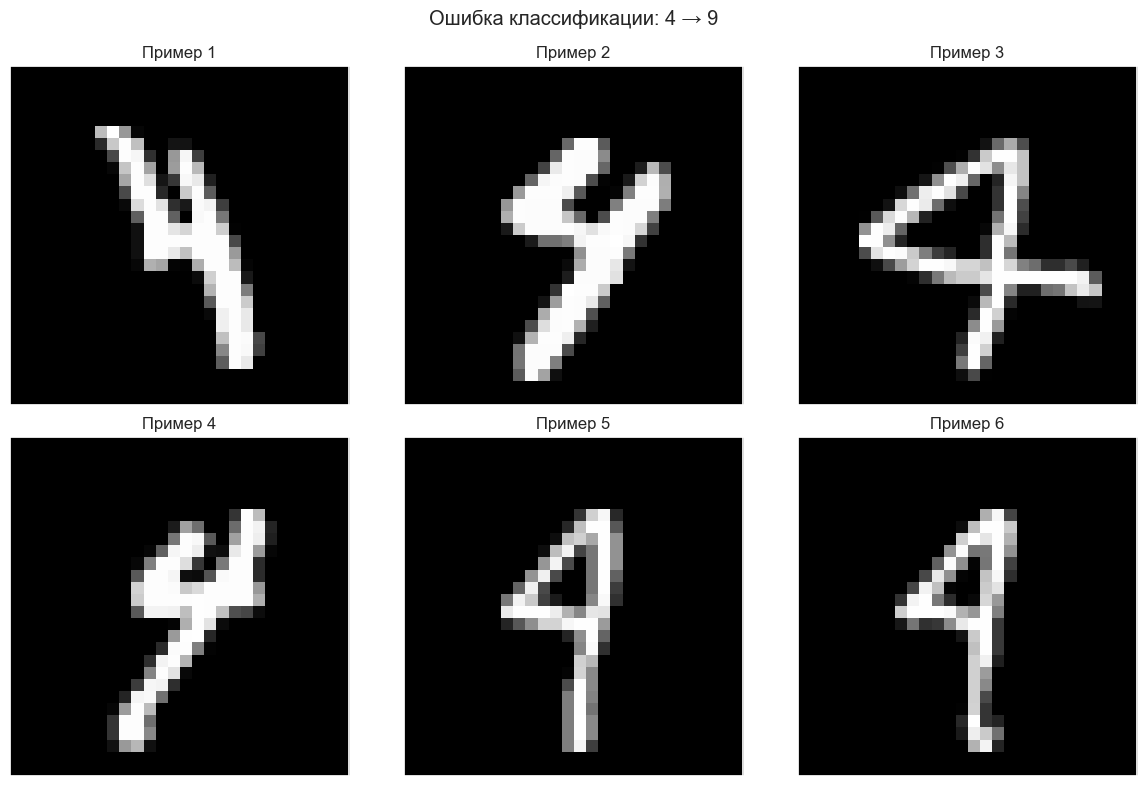

Визуализация ошибок 8 -> 3 (количество: 10)


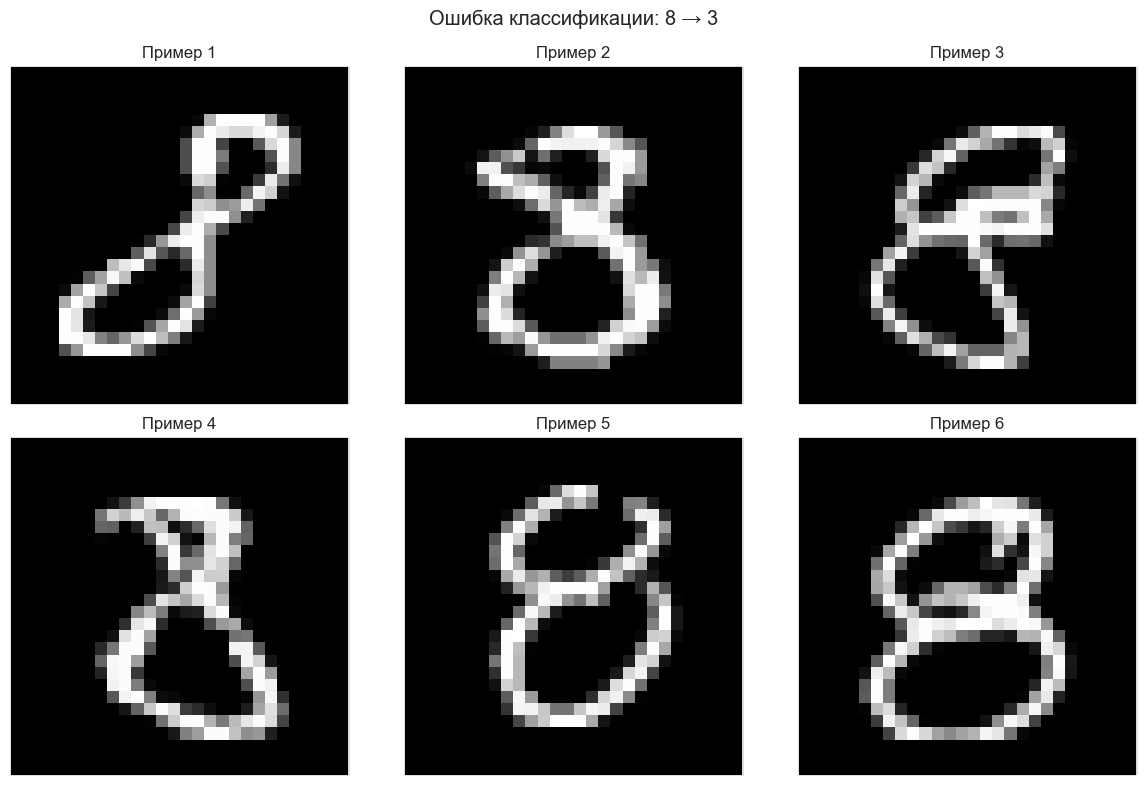

Визуализация ошибок 3 -> 2 (количество: 10)


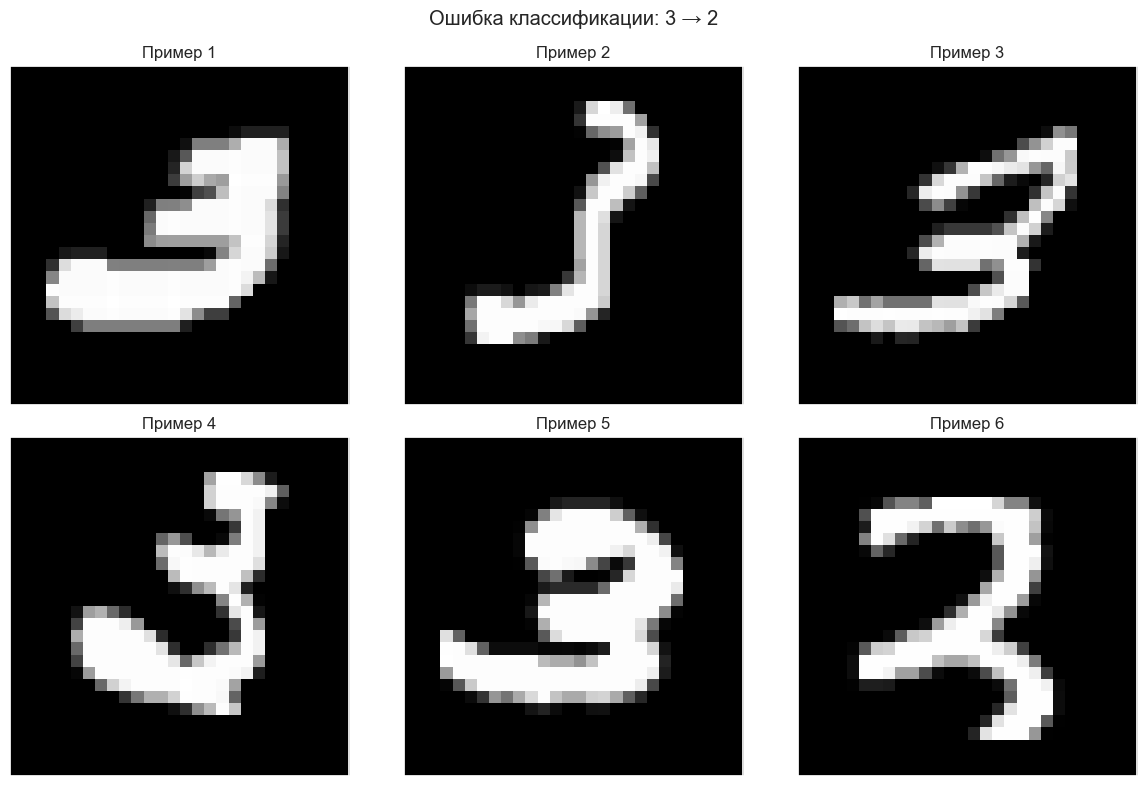

Визуализация ошибок 8 -> 9 (количество: 9)


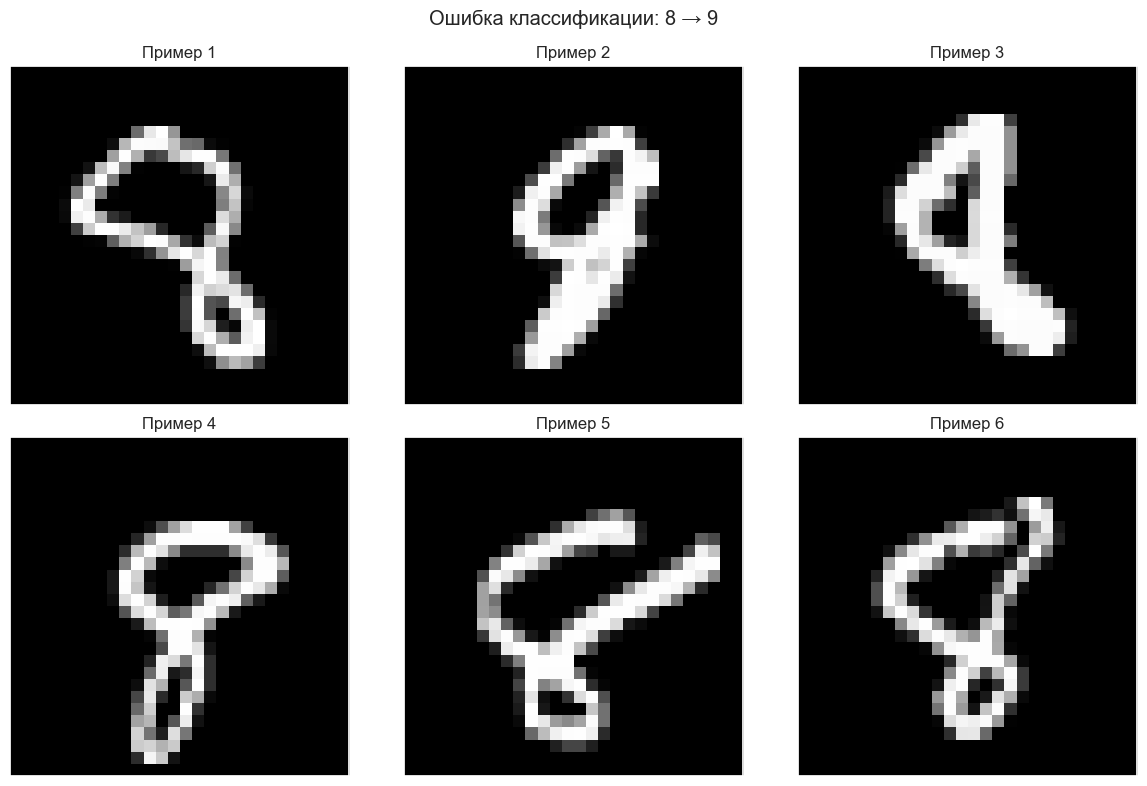

In [28]:
# Визуализация примеров ошибок
if len(error_counts) > 0:
    # Выбираются 5 самых частых ошибок
    common_errors = error_counts.head(5)

    for i in range(len(common_errors)):
        true_class = common_errors.iloc[i]['Истинный класс']
        pred_class = common_errors.iloc[i]['Предсказанный класс']
        count = common_errors.iloc[i]['Количество']

        print(f'Визуализация ошибок {true_class} -> {pred_class} '
              f'(количество: {count})')

        # Нахождение примеров этой ошибки
        error_indices = np.where(
            (y_errors_true == true_class) & (y_errors_pred == pred_class))[0]

        # Выбор не более 6 примеров ошибки
        examples_to_show = min(6, len(error_indices))

        # Отдельный график для каждой ошибки
        n_cols = 3
        n_rows = (examples_to_show + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
        # Преобразование axes в массив для единообразия,
        # если есть только одна строка
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        plot_idx = 0

        for j in range(examples_to_show):
            idx = error_indices[j]
            actual_idx = x_errors.index[idx]
            pixels = x_val.loc[actual_idx].values

            # Вычисление координат subplot
            row = plot_idx // n_cols
            col = plot_idx % n_cols

            ax = print_image(pixels=pixels, ax=axes[row, col],
                             title=f'Пример {j+1}')
            plot_idx += 1

        # Скрытие неиспользованных subplots
        for k in range(plot_idx, n_rows * n_cols):
            row = k // n_cols
            col = k % n_cols
            axes[row, col].set_visible(False)

        fig.suptitle(f'Ошибка классификации: {true_class} → {pred_class}')
        plt.tight_layout()
        plt.show()
else:
    print('Нет ошибок для визуализации!')

Анализ ошибок классификации выявил две основные группы. Первая — это ошибки, обусловленные перекрытием признаков в данных, где цифры объективно похожи. Вторая, более проблемная группа — это ошибки без видимой закономерности. Их наличие свидетельствует о том, что текущая модель, вероятно, достигла своего предела. Это указывает на потенциальное направление для улучшения — использование более сложной архитектуры.

### Оценка качества лучшей модели на тестовой выборке

In [29]:
best_test_pred = best_model.predict(x_test)

best_test_accuracy = accuracy_score(y_test, best_test_pred)
best_test_precision = precision_score(y_test, best_test_pred,
                                      average='weighted', zero_division=0)
best_test_recall = recall_score(y_test, best_test_pred,
                                average='weighted', zero_division=0)
best_test_f1 = f1_score(y_test, best_test_pred,
                        average='weighted', zero_division=0)

print(f'Метрики качества модели {best_model_name} на тестовой выборке:')
print(f'Accuracy: {best_test_accuracy}')
print(f'Precision: {best_test_precision}')
print(f'Recall: {best_test_recall}')
print(f'F1-score: {best_test_f1}')

Метрики качества модели RF_est_1000 на тестовой выборке:
Accuracy: 0.9576190476190476
Precision: 0.9576405928911773
Recall: 0.9576190476190476
F1-score: 0.9576117218040346


Сходство метрик качества на валидационной и тестовой выборках указывает на отсутствие переобучения модели.

In [30]:
print('Отчёт о классификации:')
report = classification_report(y_test, best_test_pred, zero_division=0,
                               output_dict=True)
display(pd.DataFrame(report).transpose())

Отчёт о классификации:


,precision,recall,f1-score,support
0,0.975806,0.989486,0.982599,856.000000
1,0.984649,0.980349,0.982495,916.000000
2,0.945813,0.952854,0.949320,806.000000
3,0.937639,0.934517,0.936076,901.000000
4,0.962740,0.968561,0.965642,827.000000
5,0.948993,0.952830,0.950908,742.000000
6,0.977860,0.974265,0.976059,816.000000
7,0.967705,0.949095,0.958310,884.000000
8,0.944511,0.943373,0.943942,830.000000
9,0.927184,0.929440,0.928311,822.000000


Модель демонстрирует высокую и сбалансированную эффективность, о чём свидетельствует общая accuracy в 95.76%. Наилучшие результаты модель показывает для цифр 0, 1 и 6, где значения F1-score превышают 97%. Небольшое снижение производительности наблюдается у цифр 9, 3 и 8, которые, вероятно, являются наиболее сложными для классификации. При этом разница между macro avg и weighted avg незначительна, что указывает на равномерное качество предсказаний по всем классам.

### Бутстрап для доверительных интервалов метрик качества

In [31]:
# Объединение тестовых данных
x_y_test = x_test.copy(deep=True)
x_y_test['label'] = y_test

boot_accuracies = []
boot_precisions = []
boot_recalls = []
boot_f1_scores = []

n_bootstraps = 1000

print(f'Выполняется бутстрап ({n_bootstraps} итераций)...')
for i in range(n_bootstraps):
    if (i + 1) % 100 == 0:
        print(f'Завершено итераций: {i + 1}/{n_bootstraps}')

    # Создание бутстрап-выборки
    x_y_test_boot = x_y_test.sample(len(x_y_test), replace=True)
    x_test_boot = x_y_test_boot.drop(columns='label')
    y_test_boot = x_y_test_boot['label']

    # Предсказания модели
    y_pred = best_model.predict(x_test_boot)

    # Вычисление метрик качества
    boot_accuracies.append(accuracy_score(y_test_boot, y_pred))
    boot_precisions.append(precision_score(y_test_boot, y_pred,
                                         average='weighted', zero_division=0))
    boot_recalls.append(recall_score(y_test_boot, y_pred,
                                   average='weighted', zero_division=0))
    boot_f1_scores.append(f1_score(y_test_boot, y_pred,
                                 average='weighted', zero_division=0))

def calculate_confidence_interval(metric_values):
    """Вычисляет доверительные интервалы (95%)"""
    sorted_metrics = np.sort(metric_values)
    lower_bound = sorted_metrics[int(0.025 * len(sorted_metrics))]
    upper_bound = sorted_metrics[int(0.975 * len(sorted_metrics))]
    return lower_bound, upper_bound

accuracy_ci = calculate_confidence_interval(boot_accuracies)
precision_ci = calculate_confidence_interval(boot_precisions)
recall_ci = calculate_confidence_interval(boot_recalls)
f1_ci = calculate_confidence_interval(boot_f1_scores)

Выполняется бутстрап (1000 итераций)...
Завершено итераций: 100/1000
Завершено итераций: 200/1000
Завершено итераций: 300/1000
Завершено итераций: 400/1000
Завершено итераций: 500/1000
Завершено итераций: 600/1000
Завершено итераций: 700/1000
Завершено итераций: 800/1000
Завершено итераций: 900/1000
Завершено итераций: 1000/1000


In [32]:
# Вывод доверительных интервалов
print('Доверительные интервалы метрик (бутстрап):')
print('Accuracy:')
print(f'Среднее значение интервала: {best_test_accuracy}')
print(f'Интервал: [{accuracy_ci[0]}, {accuracy_ci[1]}]')
print(f'Описание интервала: (95% ДИ, ширина: {
    accuracy_ci[1] - accuracy_ci[0]})')

print('\nPrecision:')
print(f'Среднее значение интервала: {best_test_precision}')
print(f'Интервал: [{precision_ci[0]}, {precision_ci[1]}]')
print(f'Описание интервала: (95% ДИ, ширина: {
    precision_ci[1] - precision_ci[0]})')

print('\nRecall:')
print(f'Среднее значение интервала: {best_test_recall}')
print(f'Интервал: [{recall_ci[0]}, {recall_ci[1]}]')
print(f'Описание интервала: (95% ДИ, ширина: {recall_ci[1] - recall_ci[0]})')

print('\nF1:')
print(f'Среднее значение интервала: {best_test_f1}')
print(f'Интервал: [{f1_ci[0]}, {f1_ci[1]}]')
print(f'Описание интервала: (95% ДИ, ширина: {f1_ci[1] - f1_ci[0]})')

Доверительные интервалы метрик (бутстрап):
Accuracy:
Среднее значение интервала: 0.9576190476190476
Интервал: [0.9533333333333334, 0.9616666666666667]
Описание интервала: (95% ДИ, ширина: 0.008333333333333304)

Precision:
Среднее значение интервала: 0.9576405928911773
Интервал: [0.9533568318526922, 0.9617579636041266]
Описание интервала: (95% ДИ, ширина: 0.00840113175143442)

Recall:
Среднее значение интервала: 0.9576190476190476
Интервал: [0.9533333333333334, 0.9616666666666667]
Описание интервала: (95% ДИ, ширина: 0.008333333333333304)

F1:
Среднее значение интервала: 0.9576117218040346
Интервал: [0.9533118317103957, 0.9616639517760689]
Описание интервала: (95% ДИ, ширина: 0.008352120065673208)


Узкие доверительные интервалы всех метрик качества подтверждают высокую стабильность и надежность модели. Это исключает переобучение и доказывает, что оценка качества на тестовой выборке объективно отражает работу модели.

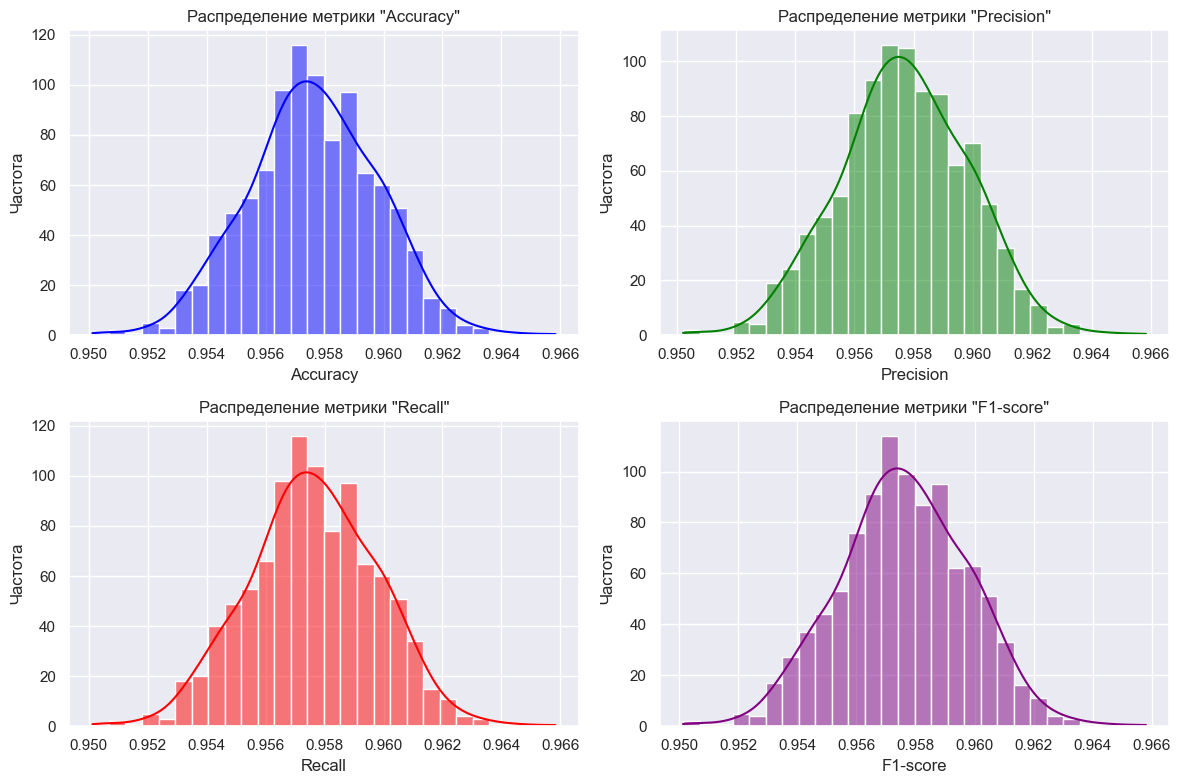

In [33]:
# Визуализация распределения метрик
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics = [boot_accuracies, boot_precisions, boot_recalls, boot_f1_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
colors = ['blue', 'green', 'red', 'purple']

for i, (ax, metric, name, color) in enumerate(zip(
        axes.flat, metrics, metric_names, colors)):
    sns.histplot(metric, ax=ax, color=color, kde=True)
    ax.set_title(f'Распределение метрики "{name}"')
    ax.set_xlabel(name)
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

### Интерпретация лучшей модели

Топ 10 самых важных пикселей:


,pixel,importance
320,pixel378,0.010568
293,pixel350,0.009475
397,pixel461,0.008172
347,pixel406,0.007963
319,pixel377,0.007834
350,pixel409,0.007810
375,pixel437,0.007550
103,pixel155,0.007217
346,pixel405,0.007087
476,pixel542,0.007055


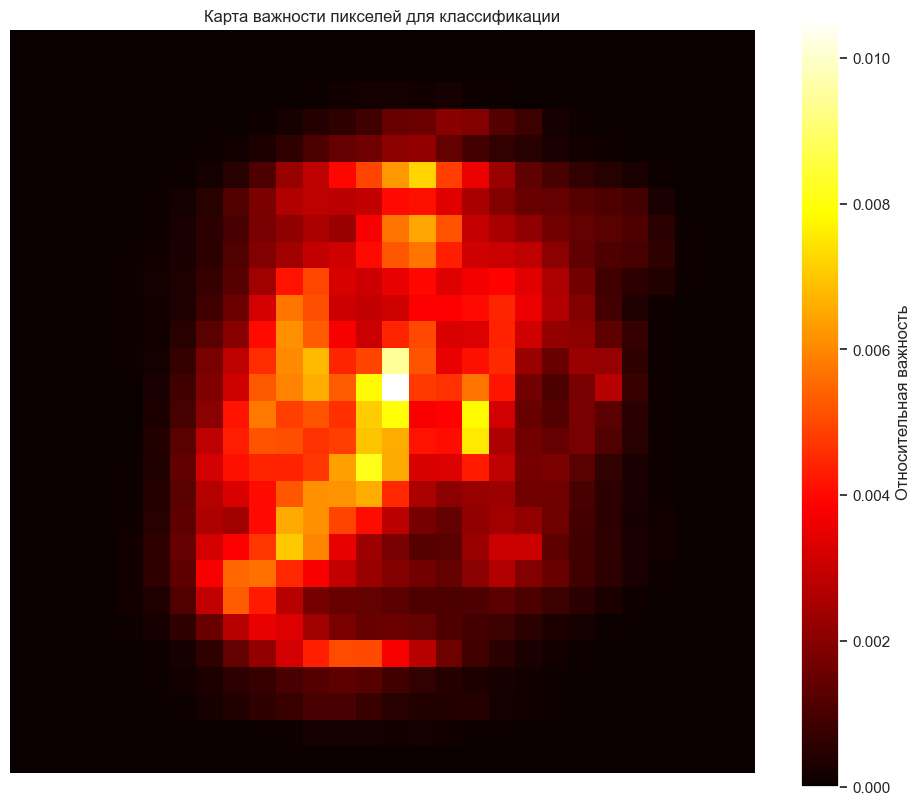

In [34]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_

    importance_df = pd.DataFrame({
        'pixel': x_train.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print('Топ 10 самых важных пикселей:')
    display(importance_df.head(10))

    # Визуализация важных пикселей на изображении 28x28
    plt.figure(figsize=(12, 10))

    # Создание карты важности пикселей
    importance_map = np.zeros(28 * 28)

    # Заполнение важных пикселей
    for i, (pixel_name, importance) in enumerate(zip(
                x_train.columns, feature_importance)):
        if pixel_name.startswith('pixel'):
            try:
                pixel_idx = int(pixel_name[5:])
                if pixel_idx < len(importance_map):
                    importance_map[pixel_idx] = importance
            except ValueError:
                continue

    # Визуализация карты важности пикселей
    plt.imshow(importance_map.reshape(28, 28), cmap='hot',
               interpolation='nearest')
    plt.colorbar(label='Относительная важность')
    plt.title('Карта важности пикселей для классификации')
    plt.axis('off')
    plt.show()

Интерпретация модели выявила, что наиболее информативные для классификации пиксели сосредоточены в центре изображения, образуя четкие кластеры значимости. Именно эти области вносят решающий вклад в принятие итогового решения.